# Testing Alpha in Asset Princing Models
To test alpha in asset pricing models using Python in a Jupyter notebook, we can use real-world financial data (e.g., from Yahoo Finance) and libraries like pandas, numpy, statsmodels, and yfinance. We'll focus on CAPM and a multi-factor model like Fama-French.

### Step 1: Install Required Libraries
First, make sure you have all necessary packages installed.

In [ ]:
!pip install yfinance statsmodels

### Step 2: Import Libraries

In [77]:
import yfinance as yf
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

### Step 3: Download Financial Data
We'll use the yfinance library to download data for a chosen asset (e.g., Apple Inc.) and a market benchmark (e.g., S&P 500).

In [94]:
# Download asset data (e.g., MSFT) and benchmark (e.g., S&P 500)
asset = yf.download('MSFT', start='2018-01-01', end='2024-01-01')['Adj Close']
market = yf.download('^GSPC', start='2018-01-01', end='2024-01-01')['Adj Close']

# Convert to daily returns
asset_returns = asset.pct_change().dropna()
market_returns = market.pct_change().dropna()

asset_returns.sum()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


2.0439043397500245

### Step 4: Calculate Excess Returns
To test for alpha, we need excess returns, which are returns above the risk-free rate. For simplicity, we’ll assume a constant risk-free rate (e.g., 0.02 annualized).

In [95]:
risk_free_rate = 0.05 / 252  # Adjusted for daily returns
excess_asset_returns = asset_returns - risk_free_rate
excess_market_returns = market_returns - risk_free_rate

### Step 5: CAPM Model (Single Factor)
Now we’ll run a regression to model the relationship between the asset’s returns and the market returns. CAPM is a simple linear regression where the excess asset return is regressed against excess market returns:

In [96]:
# Add constant for intercept (alpha)
X = sm.add_constant(excess_market_returns)
y = excess_asset_returns

# Run OLS regression
capm_model = sm.OLS(y, X).fit()

# Display the results
print(capm_model.summary())

                            OLS Regression Results                            
Dep. Variable:              Adj Close   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.527
Method:                 Least Squares   F-statistic:                     1683.
Date:                Mon, 09 Sep 2024   Prob (F-statistic):          1.35e-247
Time:                        10:21:36   Log-Likelihood:                 4116.5
No. Observations:                1508   AIC:                            -8229.
Df Residuals:                    1506   BIC:                            -8218.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.000      2.008      0.0

### Step 6: Fama-French 3-Factor Model (Multi-Factor)
We can extend this by using the Fama-French 3-Factor model, which includes market risk, size, and value factors. You can download the Fama-French data from Kenneth French’s website or use a pre-built dataset from yfinance:

In [97]:
# Load your CSV file
ff_factors = pd.read_csv('C:\\Users\\Student User\\Downloads\\Data\\FF_Research.csv')

# Convert the 'Date' column to string to use the str methods
ff_factors['Date'] = ff_factors['Date'].astype(str)

# Remove rows that are not date entries (i.e., rows where 'Date' is not numeric)
ff_factors = ff_factors[ff_factors['Date'].str.isdigit()]

# Convert the 'Date' column to datetime format
ff_factors['Date'] = pd.to_datetime(ff_factors['Date'], format='%Y%m%d')

# Rename the columns to match Fama-French factors
ff_factors.rename(columns={
    'Mkt-RF': 'Market_Risk_Premium',
    'SMB': 'Size_Factor',
    'HML': 'Value_Factor',
    'RF': 'Risk_Free_Rate'
}, inplace=True)

# Set the 'Date' column as the index
ff_factors.set_index('Date', inplace=True)

# Filter the dataset to include only data from 2018-01-01 to 2024-12-31
ff_factors_filtered = ff_factors.loc['2018-01-01':'2024-01-01']

# Display the first few rows of the filtered dataset
print(ff_factors_filtered.head())

            Market_Risk_Premium  Size_Factor  Value_Factor  Risk_Free_Rate
Date                                                                      
2018-01-02                 0.85         0.35         -0.22           0.006
2018-01-03                 0.59        -0.39         -0.18           0.006
2018-01-04                 0.42        -0.26          0.24           0.006
2018-01-05                 0.66        -0.36         -0.26           0.006
2018-01-08                 0.19        -0.15          0.04           0.006


In [98]:
# Subtract risk-free rate from the asset returns to get excess returns
excess_asset_returns = asset_returns - ff_factors_filtered['Risk_Free_Rate']

# Prepare the Fama-French factors for regression
X_ff = sm.add_constant(ff_factors_filtered[['Market_Risk_Premium', 'Size_Factor', 'Value_Factor']])

# Run the OLS regression (CAPM + Fama-French factors)
ff_model = sm.OLS(excess_asset_returns, X_ff).fit()

In [99]:
# Check for missing values in asset returns or Fama-French factors
print(asset_returns.isna().sum())
print(ff_factors_filtered.isna().sum())

# Drop rows with missing values in either dataset
aligned_data = pd.concat([excess_asset_returns, ff_factors_filtered], axis=1).dropna()

# Separate the dependent and independent variables after alignment
y_aligned = aligned_data.iloc[:, 0]  # Excess asset returns
X_aligned = sm.add_constant(aligned_data[['Market_Risk_Premium', 'Size_Factor', 'Value_Factor']])

# Run the OLS regression again
ff_model_aligned = sm.OLS(y_aligned, X_aligned).fit()

# Display the updated regression results
print(ff_model_aligned.summary())

0
Market_Risk_Premium    0
Size_Factor            0
Value_Factor           0
Risk_Free_Rate         0
dtype: int64
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     516.0
Date:                Mon, 09 Sep 2024   Prob (F-statistic):          1.73e-230
Time:                        10:21:50   Log-Likelihood:                 4028.3
No. Observations:                1508   AIC:                            -8049.
Df Residuals:                    1504   BIC:                            -8027.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
-------

### Step 7: Interpret Results
Looking at the **CAPM results for Microsoft (MSFT) vs S&P 500**, here is the interpretation of the regression output:

#### Alpha (Intercept: -0.0062):
- The **alpha** is **-0.0062**, meaning that Microsoft's stock has a negative alpha of about **-0.62%** per day on average, after controlling for the market, size, and value factors. This suggests that Microsoft tends to underperform by this amount relative to what CAPM predicts.
- The p-value for the alpha is 0.000, indicating that this result is statistically significant.

#### Beta (Market Risk Premium: 0.0125):
- The **beta** is **0.0125**, meaning that for each 1% increase in the market's excess returns (S&P 500), Microsoft's excess returns increase by **1.25%**.
- The p-value for this coefficient is very small (close to 0), indicating that this relationship is statistically significant.

#### Size Factor (0.0011):
- The **size factor** (SMB) is **0.0011** and is not statistically significant (p-value = 0.092). This means that the size of the company (in terms of market capitalization) doesn't play a significant role in explaining Microsoft's returns relative to the market in this model.

#### Value Factor (-0.0016):
- The **value factor** (HML) is **-0.0016**, suggesting a negative relationship between Microsoft's performance and the value factor. Microsoft's stock tends to behave more like a growth stock than a value stock (since growth stocks tend to have negative exposure to the value factor). This result is statistically significant with a p-value of 0.000.

#### Model Fit (R-squared: 0.507):
- The R-squared is **0.507**, meaning the model explains about **50.7%** of the variance in Microsoft's returns. This is a decent fit, but there are other factors not captured by the model that could further explain the variance in returns.

#### Conclusion:
- Microsoft's **alpha** is **negative** and statistically significant, meaning it has underperformed relative to what CAPM predicts.
- The **market factor (beta)** is positive and significant, showing that Microsoft has a strong correlation with the market.
- The **size factor** is not significant, suggesting size does not influence Microsoft's returns significantly.
- The **value factor** is negative and significant, indicating Microsoft behaves more like a growth stock than a value stock.


In [100]:
aligned_data = pd.concat([excess_market_returns, excess_asset_returns], axis=1).dropna()
excess_market_returns_aligned = aligned_data.iloc[:, 0]
excess_asset_returns_aligned = aligned_data.iloc[:, 1]

### Step 8: Visualization
To make this more visually appealing, we can plot the asset returns vs. market returns:

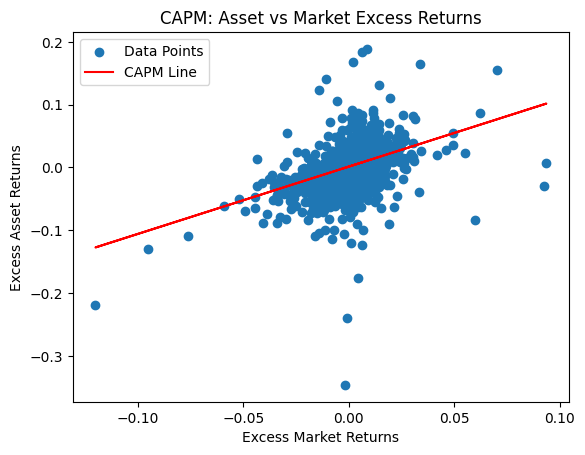

In [93]:
plt.scatter(excess_market_returns_aligned, excess_asset_returns_aligned, label='Data Points')
plt.plot(excess_market_returns_aligned, capm_model.predict(X), color='red', label='CAPM Line')
plt.title('CAPM: Asset vs Market Excess Returns')
plt.xlabel('Excess Market Returns')
plt.ylabel('Excess Asset Returns')
plt.legend()
plt.show()

The **CAPM (Capital Asset Pricing Model) graph** shows the relationship between **excess returns of an asset (MSFT) and excess market returns (S&P 500)**.

### Here's what the graph represents:

1. **X-Axis (Excess Market Returns)**:
   - The horizontal axis represents the **excess returns of the market**, which is typically calculated as the **returns of the market (e.g., S&P 500) minus the risk-free rate**.
   
2. **Y-Axis (Excess Asset Returns)**:
   - The vertical axis represents the **excess returns of the asset** (MSFT), which is the **returns of the asset minus the risk-free rate**.

3. **Data Points**:
   - The **blue scatter points** represent actual historical data for excess returns of the asset vs. excess returns of the market. Each point corresponds to one observation period (e.g., daily or monthly data).

4. **CAPM Line (Red Line)**:
   - The **red line** represents the **CAPM regression line**, which is a linear relationship between the excess market returns (X-axis) and excess asset returns (Y-axis). This line is derived from the **beta** calculated by the CAPM regression.
   - It shows the expected excess returns of the asset based on the excess returns of the market.

### Key Observations:
- **Slope (Beta)**: 
   - The slope of the red line indicates the **beta** of the asset with respect to the market. A **positive slope** suggests that the asset's returns generally move in the same direction as the market returns. 
   - In this case, the slope is **positive**, meaning the asset tends to increase when the market increases.
   
- **Spread of Data Points**:
   - The scatter points are somewhat spread around the red CAPM line. The tighter the points are to the line, the better the model fits the data. In this case, there is some variation, which suggests that while CAPM explains some of the asset's performance, there are other factors influencing returns.
   
- **Outliers**:
   - There are a few **outliers** far from the red line, indicating that the asset had returns that significantly deviated from what the CAPM predicted for those time periods.

### In summary:
This image represents the relationship between an asset's excess returns and the market's excess returns as predicted by the CAPM model. The red line shows the theoretical relationship (based on the CAPM regression), while the blue points represent the actual data. The positive slope of the CAPM line indicates a positive beta, meaning the asset tends to move in the same direction as the market, though there are deviations as indicated by the scattered data points.